# Yacine Boureghda & Yanis Belami #

### Importing all necessary libraries

In [1]:
import os
import shutil
from collections import Counter
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import cv2
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.class_weight import compute_class_weight
from scipy.stats import zscore
from sklearn.metrics import confusion_matrix, classification_report

from skimage import exposure
from skimage.util import random_noise
from skimage.filters import gaussian

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, LSTM, GlobalAveragePooling2D, SpatialDropout2D, BatchNormalization, Activation, Reshape, TimeDistributed, Input
from tensorflow.keras.models import Sequential, model_from_json, Model
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, Callback

from keras.regularizers import l2
from IPython.display import FileLink
from tensorflow.keras.mixed_precision import Policy, set_global_policy
from tensorflow.keras.mixed_precision import LossScaleOptimizer

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

2024-06-12 16:32:56.672969: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 16:32:56.673095: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 16:32:56.811417: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/navires-2024-fait-main/ships24.tgz


In [2]:
!tar xzf /kaggle/input/navires-2024-fait-main/ships24.tgz
!ls /kaggle/working/*

/kaggle/working/__notebook__.ipynb  /kaggle/working/test.npy

/kaggle/working/ships_gray:
coastguard_scaled     cruiser_scaled	methanier_scaled  tug_scaled
containership_scaled  cv_scaled		smallfish_scaled
corvette_scaled       destroyer_scaled	submarine_scaled


### Fixed seed for reproducibility

In [3]:
# Set random seeds for reproducibility

seed_value = 1926
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# seed for the GPU backend
#os.environ['PYTHONHASHSEED'] = str(seed_value)
#os.environ['TF_CUDNN_DETERMINISTIC'] = '1'   ### 1 = true anything else = false 
#os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Setting mixed precision policy
#policy = Policy('mixed_float16')
#set_global_policy(policy)

### Outlier Detection and Removal

In this section, we will perform exploratory data analysis (EDA) to identify and remove outlier images from our dataset based on histogram analysis. Outlier images are those with a high proportion of pixels of the same value, which may indicate poor quality or corrupted images.


In [4]:
def is_outlier(hist, threshold): #0.4 = 40deleted   #0.3 = 122   #0.35 = 81 #0.2=373
    total_pixels = np.sum(hist)
    max_pixel_value_proportion = np.max(hist) / total_pixels
    return max_pixel_value_proportion > threshold

def log_outlier(log_file, subdir, img_name):
    with open(log_file, 'a') as f:
        f.write(f'{subdir}, {img_name}\n')

def run_eda_and_remove_outliers(data_dir, train_dir, threshold=0.2, outliers_to_print=5, log_file='removed_outliers.log'):
    outliers_count = 0
    if os.path.exists(log_file):
        os.remove(log_file)
    subdirectories = [subdir for subdir in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, subdir))]

    for subdir in subdirectories:
        img_names = Path(train_dir).glob(f'{subdir}/*')
        pbar = tqdm(list(img_names), desc=f'Processing {subdir}')
        for img_name in pbar:
            if img_name.is_file():
                img = load_img(img_name.as_posix(), color_mode='grayscale')
                img_array = img_to_array(img)
                hist = cv2.calcHist([img_array], [0], None, [256], [0, 256])
                if is_outlier(hist, threshold):
                    os.remove(img_name)
                    log_outlier(log_file, subdir, img_name.name)
                    outliers_count += 1

    print(f'Total number of outliers removed: {outliers_count}')
    print(f'Outliers details logged in: {log_file}')

data_dir = '/kaggle/working/ships_gray/'

RUN_EDA = True

if RUN_EDA:
    run_eda_and_remove_outliers(data_dir, data_dir)
else:
    print('RUN_EDA is False')

Processing methanier_scaled: 100%|██████████| 3525/3525 [00:02<00:00, 1618.98it/s]

Total number of outliers removed: 373
Outliers details logged in: removed_outliers.log


### Data Splitting and Directory Creation

In this section, we will split the dataset into training and validation sets. We will create separate directories for training and validation data, and distribute the files accordingly.


In [5]:
data_dir = '/kaggle/working/ships_gray/'

subdirectories = [subdir for subdir in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, subdir))]

train_dir = '/kaggle/working/training_data'
val_dir = '/kaggle/working/validation_data'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for subdir in subdirectories:
    files = os.listdir(os.path.join(data_dir, subdir))
    train_files, val_files = train_test_split(files, test_size=0.2, random_state=seed_value)
    for file in train_files:
        src = os.path.join(data_dir, subdir, file)
        dst = os.path.join(train_dir, subdir, file)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)  
    for file in val_files:
        src = os.path.join(data_dir, subdir, file)
        dst = os.path.join(val_dir, subdir, file)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)  

print("Data splitting and directory creation completed!")

Data splitting and directory creation completed!


### Data Augmentation and Data Generator Setup

In this section, we will set up data augmentation and data generators for training and validation datasets. Data augmentation helps in improving the generalization of the model by creating variations of the images in the training set. 

We include the `add_noise_and_blur` function in this notebook, even though it is not used in the final implementation. We initially thought it could be beneficial for enhancing the data, but in practice, it did not provide the desired improvements.

In [6]:
batch_size = 512
image_size = (64, 96)

batch_size2 = 32
image_size2 = (128, 192)

def add_noise_and_blur(image, noise_sd=0.001, blur_sigma=0.1):
    if image.max() > 1:
        image = image / 255.0
    noisy_image = random_noise(image, mode='gaussian', var=noise_sd)
    #blurred_image = gaussian(noisy_image, sigma=blur_sigma)
    noisy_image = np.clip(noisy_image, 0., 1.)  
    return noisy_image
    
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,      
    width_shift_range=0.1,  
    height_shift_range=0.1, 
    zoom_range=0.2,         
    horizontal_flip=True, 
    #preprocessing_function=add_noise_and_blur
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

train_dataset = train_datagen.flow_from_directory(
    '/kaggle/working/training_data',
    target_size=image_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
)

validation_dataset = val_datagen.flow_from_directory(
    '/kaggle/working/validation_data',
    target_size=image_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
)

Found 33460 images belonging to 10 classes.
Found 8371 images belonging to 10 classes.


### Strategy for Enhancing Accuracy

Based on insights from several research papers, we employed a strategy of training the same model with different parameters in several phases. Initially, we used low-resolution images with a large batch size, followed by high-resolution images with a smaller batch size. This approach aims to balance computational efficiency and model accuracy.

After multiple trials and errors, we found that reducing the resolution by half and adjusting the batch size accordingly yielded the best results. Using a very large batch size in the beginning did not provide significant improvements in accuracy, while too small a batch size was time-consuming without offering better accuracy. 

At the end of this notebook, we have provided references to the research papers that guided our approach.

### Model Architecture Creation

In this section, we define a function to create a Convolutional Neural Network (CNN) model using the Keras Sequential API. The model consists of several convolutional layers, batch normalization layers, max pooling layers, dropout layers, and fully connected layers.

We experimented with several state-of-the-art CNN architectures, including ResNet, DenseNet, InceptionNet, AlexNet, and GoogLeNet, aiming to reduce them to less than 30 layers. However, the most effective model, both computationally and in terms of accuracy, turned out to be a tuned version of the VGG architecture, which we describe below.

In [7]:
def create_model(input_shape):
    model = Sequential()
    
    model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(Dropout(0.34))

    model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(Dropout(0.36))

    model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(Dropout(0.38))

    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    return model


size1 = (64, 96, 1)
size2 = (128, 192, 1)

model = create_model(size1)
print("Nombre de couches : ", len(model.layers))
print('ok')
print(model.summary())

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Nombre de couches :  29
ok


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 96, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 96, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 96, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 96, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 48, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 48, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 48, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 48, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 24, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 24, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 24, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 24, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 12, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 12, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 12, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 12, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 12, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 9,962,762 (38.00 MB)

 Trainable params: 9,957,130 (37.98 MB)

 Non-trainable params: 5,632 (22.00 KB)

None


### Class Weight Calculation

Upon analyzing the dataset, we observed that it is imbalanced. To address this issue, we calculate and apply class weights. Class weights are used to assign higher importance to underrepresented classes during training, thereby helping to improve the model's performance on an imbalanced dataset.


In [8]:
class_weight_dict = {
    'class_weight': 'balanced',
    'classes': np.unique(train_dataset.classes),
    'y': train_dataset.classes
}

class_weights = compute_class_weight(**class_weight_dict)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print('Class weights for all 10 classes:', class_weights_dict)

Class weights for all 10 classes: {0: 1.217612809315866, 1: 0.6028828828828828, 2: 1.423224159931944, 3: 0.6050632911392405, 4: 2.09125, 5: 0.6403827751196173, 6: 1.195, 7: 1.253183520599251, 8: 1.489759572573464, 9: 1.2211678832116788}


### Model Training and Fine-Tuning

In this section, we define the training and fine-tuning processes for our model. We use different learning rates, batch sizes, and image resolutions in two phases to improve the model's accuracy and generalization.

We found that using label smoothing between 0.1 and 0.2 yielded improvements for our model. We also tested many optimizers, but none outperformed the classic good old Adam optimizer in terms of efficiency and effectiveness.

We decided to prioritize the reduction of validation loss over accuracy during training, as focusing on loss produced more significant improvements in the early stages of our research. To support this approach, we use several callbacks: 
- `ReduceLROnPlateau` to monitor and reduce the learning rate when the validation loss plateaus.
- `ModelCheckpoint` to save the best model weights based on validation loss, ensuring that we can continue training if interrupted.

This part of the training process uses 80-90% of the dataset for training while keeping the rest for validation.


In [9]:
epochs = 300 
label_smoothing=0.2
loss_smooth = tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing)

base_optimizer = Adam(learning_rate=0.002)
optimizer = LossScaleOptimizer(base_optimizer)
model.compile(optimizer=optimizer, loss=loss_smooth, metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=16, restore_best_weights=True, verbose=2)
checkpoint_filepath = '/kaggle/working/model1.weights.h5'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_loss', mode='min',save_best_only=True)

history = model.fit(
    train_dataset, 
    epochs=50,
    validation_data=validation_dataset,
    callbacks=[reduce_lr, early_stopping, model_checkpoint_callback], 
    verbose=2,
    class_weight=class_weights_dict,
)

size2 = (128, 192, 1)
model = create_model(size2)

loss_smooth = tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing)
base_optimizer = Adam(learning_rate=0.0002)
optimizer = LossScaleOptimizer(base_optimizer)
model.compile(optimizer=optimizer, loss=loss_smooth, metrics=['accuracy'])
model.load_weights('/kaggle/working/model1.weights.h5')

fine_tune_train_dataset = train_datagen.flow_from_directory(
    '/kaggle/working/training_data',
    target_size=image_size2,
    batch_size=batch_size2,
    color_mode='grayscale',
    class_mode='categorical',
)

fine_tune_validation_dataset = val_datagen.flow_from_directory(
    '/kaggle/working/validation_data',
    target_size=image_size2,
    batch_size=batch_size2,
    color_mode='grayscale',
    class_mode='categorical',
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=16, restore_best_weights=True, verbose=2)
checkpoint_filepath2 = '/kaggle/working/model2.weights.h5'
model_checkpoint_callback2 = ModelCheckpoint(filepath=checkpoint_filepath2,save_weights_only=True,monitor='val_loss', mode='min',save_best_only=True)

history = model.fit(
    fine_tune_train_dataset, 
    epochs=50,
    validation_data=fine_tune_validation_dataset,
    callbacks=[reduce_lr, early_stopping, model_checkpoint_callback2], 
    verbose=2,
    class_weight=class_weights_dict,
)

print('Training and fine-tuning completed for the partial dataset')

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-06-12 16:34:43.071079: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=2} for conv (f32[512,256,32,48]{3,2,1,0}, u8[0]{0}) custom-call(f32[512,256,32,48]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-12 16:34:43.090614: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.019649459s
Trying algorit

66/66 - 318s - 5s/step - accuracy: 0.1767 - loss: 2.3196 - val_accuracy: 0.1429 - val_loss: 2.5941 - learning_rate: 0.0020
Epoch 2/50
66/66 - 61s - 919ms/step - accuracy: 0.2897 - loss: 2.1239 - val_accuracy: 0.0761 - val_loss: 2.3707 - learning_rate: 0.0020
Epoch 3/50
66/66 - 60s - 907ms/step - accuracy: 0.3779 - loss: 2.0083 - val_accuracy: 0.0819 - val_loss: 2.8546 - learning_rate: 0.0020
Epoch 4/50
66/66 - 60s - 903ms/step - accuracy: 0.4663 - loss: 1.8839 - val_accuracy: 0.0806 - val_loss: 3.1725 - learning_rate: 0.0020
Epoch 5/50
66/66 - 60s - 903ms/step - accuracy: 0.5420 - loss: 1.7626 - val_accuracy: 0.1445 - val_loss: 2.6187 - learning_rate: 0.0020
Epoch 6/50
66/66 - 60s - 910ms/step - accuracy: 0.6020 - loss: 1.6511 - val_accuracy: 0.0717 - val_loss: 4.0312 - learning_rate: 0.0020
Epoch 7/50
66/66 - 60s - 915ms/step - accuracy: 0.6453 - loss: 1.5691 - val_accuracy: 0.1543 - val_loss: 2.7418 - learning_rate: 0.0020
Epoch 8/50
66/66 - 60s - 916ms/step - accuracy: 0.6898 - loss

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer_1', because it has 4 variables whereas the saved optimizer has 82 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 78 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Found 33460 images belonging to 10 classes.
Found 8371 images belonging to 10 classes.
Epoch 1/50


2024-06-12 17:17:27.289150: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.02853, expected 1.33474
2024-06-12 17:17:27.289221: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.24699, expected 1.5532
2024-06-12 17:17:27.289232: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.46782, expected 1.77404
2024-06-12 17:17:27.289242: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.63004, expected 1.93625
2024-06-12 17:17:27.289251: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 1.98197, expected 1.28819
2024-06-12 17:17:27.289261: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.66898, expected 1.9752
2024-06-12 17:17:27.289270: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.8508, expected 2.15701
2024-06-12 17:17:27.289279: E external/local_xla/xla/servi

1046/1046 - 345s - 330ms/step - accuracy: 0.8349 - loss: 1.2123 - val_accuracy: 0.8518 - val_loss: 5.1774 - learning_rate: 2.0000e-04
Epoch 2/50
1046/1046 - 222s - 213ms/step - accuracy: 0.8633 - loss: 1.1482 - val_accuracy: 0.8615 - val_loss: 6.4934 - learning_rate: 2.0000e-04
Epoch 3/50
1046/1046 - 262s - 250ms/step - accuracy: 0.8804 - loss: 1.1183 - val_accuracy: 0.8454 - val_loss: 6.7310 - learning_rate: 2.0000e-04
Epoch 4/50
1046/1046 - 223s - 213ms/step - accuracy: 0.8907 - loss: 1.0967 - val_accuracy: 0.8931 - val_loss: 3.9083 - learning_rate: 2.0000e-04
Epoch 5/50
1046/1046 - 223s - 213ms/step - accuracy: 0.9011 - loss: 1.0776 - val_accuracy: 0.8921 - val_loss: 3.7992 - learning_rate: 2.0000e-04
Epoch 6/50
1046/1046 - 222s - 213ms/step - accuracy: 0.9087 - loss: 1.0650 - val_accuracy: 0.8621 - val_loss: 4.5380 - learning_rate: 2.0000e-04
Epoch 7/50
1046/1046 - 222s - 213ms/step - accuracy: 0.9105 - loss: 1.0560 - val_accuracy: 0.8731 - val_loss: 4.5501 - learning_rate: 2.0000e

### Evaluation and Visualization

In this section, we evaluate the performance of our model using a confusion matrix and classification report. Additionally, we visualize the training history to understand the model's learning process over epochs.


262/262 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step


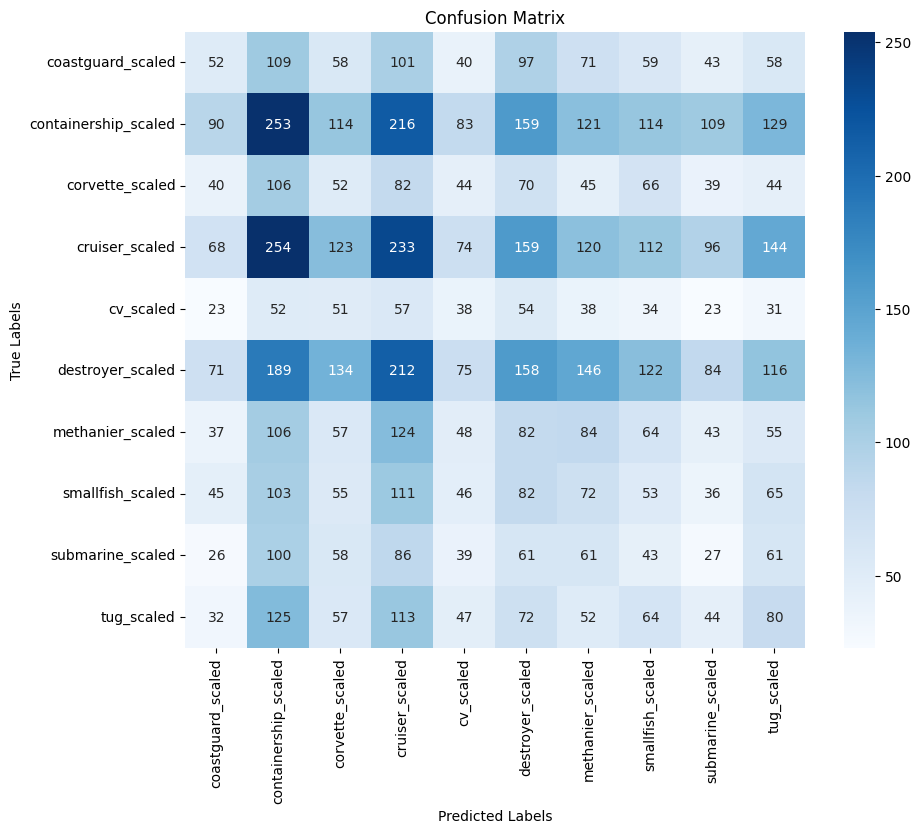

Classification Report:
                      precision    recall  f1-score   support

   coastguard_scaled       0.11      0.08      0.09       688
containership_scaled       0.18      0.18      0.18      1388
     corvette_scaled       0.07      0.09      0.08       588
      cruiser_scaled       0.17      0.17      0.17      1383
           cv_scaled       0.07      0.09      0.08       401
    destroyer_scaled       0.16      0.12      0.14      1307
    methanier_scaled       0.10      0.12      0.11       700
    smallfish_scaled       0.07      0.08      0.08       668
    submarine_scaled       0.05      0.05      0.05       562
          tug_scaled       0.10      0.12      0.11       686

            accuracy                           0.12      8371
           macro avg       0.11      0.11      0.11      8371
        weighted avg       0.13      0.12      0.12      8371



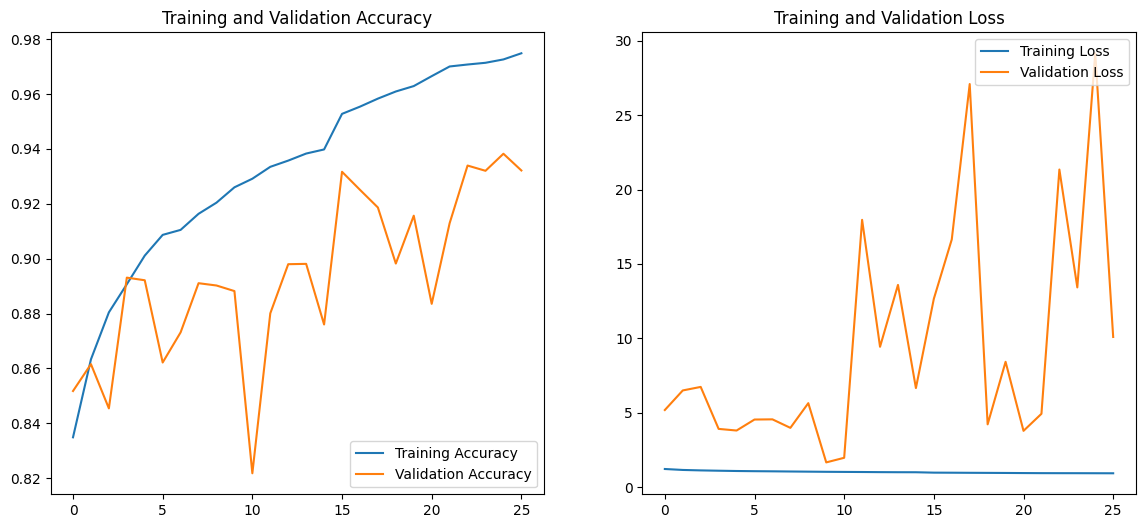

In [10]:
true_labels = fine_tune_validation_dataset.classes
predictions = model.predict(fine_tune_validation_dataset)
predicted_labels = np.argmax(predictions, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=fine_tune_validation_dataset.class_indices, yticklabels=fine_tune_validation_dataset.class_indices)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

report = classification_report(true_labels, predicted_labels, target_names=fine_tune_validation_dataset.class_indices)
print('Classification Report:')
print(report)

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)

### Model Evaluation

In this section, we load the best weights from the fine-tuning phase and evaluate the model on the validation dataset. This step allows us to assess the performance of the model in terms of loss and accuracy after the training and fine-tuning processes.


In [11]:
model.load_weights('/kaggle/working/model2.weights.h5')

loss, accuracy= model.evaluate(validation_dataset)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

W0000 00:00:1718218598.401748      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 265ms/step - accuracy: 0.7364 - loss: 1.4765
Validation Loss: 1.6396849155426025
Validation Accuracy: 0.7183132171630859


### Model Prediction and Initial Submission

In this section, we load the test dataset, preprocess it, and use the trained model to make predictions. The results are then saved to a CSV file for submission. This allows us to get an initial evaluation of the performance of our model.

In [12]:
X_test = np.load('/kaggle/working/test.npy', allow_pickle=True)
print(X_test.shape)
X_test = X_test.astype('float32') / 255

model.load_weights('/kaggle/working/model2.weights.h5')
res = model.predict(X_test).argmax(axis=1)
df = pd.DataFrame({"Category":res})
df.to_csv("submission.csv", index_label="ID")
os.chdir(r'/kaggle/working')
FileLink(r'submission.csv')

(1017, 128, 192)
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

2024-06-12 18:56:47.558967: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.61324, expected 0.662364
2024-06-12 18:56:47.559033: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.12558, expected 1.17471
2024-06-12 18:56:47.559044: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 1.97103, expected 1.02015
2024-06-12 18:56:47.559053: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.17737, expected 1.22649
2024-06-12 18:56:47.559062: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 1.97156, expected 1.02069
2024-06-12 18:56:47.559071: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 1.78131, expected 0.830437
2024-06-12 18:56:47.559080: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.55513, expected 1.60426
2024-06-12 18:56:47.559089: E external/local_xla/xla/

32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 564ms/step


/kaggle/working/submission.csv

### Last Round !

In this section, we repeat the same process as before, but with some important adjustments. This time, we will train on the entire dataset with a slightly smaller batch size and a reduced learning rate. These changes are necessary because the model has already been trained over several epochs, and we want to fine-tune it further for optimal performance.


In [13]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,      
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    #preprocessing_function=add_noise_and_blur,
)

dataset = datagen.flow_from_directory(
    '/kaggle/working/ships_gray',
    target_size=image_size2,
    batch_size=16,
    color_mode='grayscale',
    class_mode='categorical'
)

loss_smooth = tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing)
base_optimizer = Adam(learning_rate=0.00005)
optimizer = LossScaleOptimizer(base_optimizer)
model.compile(optimizer=optimizer, loss=loss_smooth, metrics=['accuracy'])
#model.load_weights('/kaggle/input/adddcanceledacc/best_model2.weights.h5')   ### in case of timeout, continue training using saved weigths from previosu training 

checkpoint = ModelCheckpoint('/kaggle/working/best_model.weights.h5', save_best_only=True, save_weights_only=True, monitor='loss', mode='min')
checkpoint2 = ModelCheckpoint('/kaggle/working/best_model2.weights.h5', save_best_only=True, save_weights_only=True, monitor='accuracy', mode='max')
early_stopping = EarlyStopping(monitor='loss', patience=20, verbose=2, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.000001)

class_weight_dict_2 = {
    'class_weight': 'balanced',
    'classes': np.unique(dataset.classes),
    'y': dataset.classes
}
class_weights_2 = compute_class_weight(**class_weight_dict)
class_weights_dict_2 = {i: class_weights[i] for i in range(len(class_weights))}

history = model.fit(
    dataset,
    epochs=30,
    verbose=2,
    callbacks=[reduce_lr, early_stopping, checkpoint, checkpoint2], 
    class_weight=class_weights_dict_2,
)

model.load_weights('/kaggle/working/best_model.weights.h5')

X_test = np.load('/kaggle/working/test.npy', allow_pickle=True)
X_test = X_test.astype('float32') / 255
res_all = model.predict(X_test).argmax(axis=1)
df = pd.DataFrame({"Category":res_all})
df.to_csv("submissionLoss.csv", index_label="ID")

os.chdir(r'/kaggle/working')
FileLink(r'submissionLoss.csv')

Found 41831 images belonging to 10 classes.
Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-06-12 18:57:17.793914: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.68172, expected 0.90198
2024-06-12 18:57:17.793976: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 1.58073, expected 0.800992
2024-06-12 18:57:17.793987: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.04324, expected 1.2635
2024-06-12 18:57:17.793995: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 1.82802, expected 1.04828
2024-06-12 18:57:17.794003: E external/local_xla/xla/service/gpu/buffer_comparator.cc:11

2615/2615 - 343s - 131ms/step - accuracy: 0.9247 - loss: 1.0269 - learning_rate: 5.0000e-05
Epoch 2/30
2615/2615 - 271s - 104ms/step - accuracy: 0.9299 - loss: 1.0160 - learning_rate: 5.0000e-05
Epoch 3/30
2615/2615 - 271s - 104ms/step - accuracy: 0.9329 - loss: 1.0084 - learning_rate: 5.0000e-05
Epoch 4/30
2615/2615 - 271s - 104ms/step - accuracy: 0.9381 - loss: 1.0005 - learning_rate: 5.0000e-05
Epoch 5/30
2615/2615 - 271s - 104ms/step - accuracy: 0.9393 - loss: 0.9959 - learning_rate: 5.0000e-05
Epoch 6/30
2615/2615 - 271s - 104ms/step - accuracy: 0.9397 - loss: 0.9947 - learning_rate: 5.0000e-05
Epoch 7/30
2615/2615 - 272s - 104ms/step - accuracy: 0.9442 - loss: 0.9863 - learning_rate: 5.0000e-05
Epoch 8/30
2615/2615 - 271s - 104ms/step - accuracy: 0.9464 - loss: 0.9814 - learning_rate: 5.0000e-05
Epoch 9/30
2615/2615 - 271s - 104ms/step - accuracy: 0.9464 - loss: 0.9796 - learning_rate: 5.0000e-05
Epoch 10/30
2615/2615 - 271s - 104ms/step - accuracy: 0.9494 - loss: 0.9762 - learni

/kaggle/working/submissionLoss.csv

Instead of only monitoring the loss, we also decided to monitor the accuracy. This approach allows us to save the best epochs for both loss and accuracy, ensuring that we can choose the best model based on different criteria if the best accuracy epoch isn't the same as the best loss epoch.

In [14]:
model.load_weights('/kaggle/working/best_model2.weights.h5')

X_test = np.load('/kaggle/working/test.npy', allow_pickle=True)
X_test = X_test.astype('float32') / 255

res_all = model.predict(X_test).argmax(axis=1)
df = pd.DataFrame({"Category":res_all})
df.to_csv("submissionAcc.csv", index_label="ID")

os.chdir(r'/kaggle/working')
FileLink(r'submissionAcc.csv')

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step


/kaggle/working/submissionAcc.csv

### References and Useful Links

In this section, we include all the useful links and references that guided our approach and methodology throughout this project. These resources provide valuable insights into various techniques and best practices in machine learning and data science.

1. [Data Augmentation for Deep Learning: A Survey](https://arxiv.org/pdf/1906.06423)
2. [Bag of Tricks for Image Classification with Convolutional Neural Networks](https://arxiv.org/pdf/1812.01187)
3. [Densely Connected Convolutional Networks](http://www.arxiv.org/pdf/1608.06993)
4. [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385)
5. [LARGE BATCH TRAINING OF CONVOLUTIONAL NETWORKS](https://arxiv.org/pdf/1708.03888)
6. [Image Classification Tips & Tricks](https://www.kaggle.com/competitions/rsna-breast-cancer-detection/discussion/372567)
7. [Kaggle Petfinder Pawpularity Score Competition Discussion](https://www.kaggle.com/competitions/petfinder-pawpularity-score/discussion/288896)

We are really thanksful to this project because it was a challenging task that forced us to make our own research and to progress, it made us grow or at least that's the feeling we have at the end of this competiton, we do fell short on time and have other nice things we would have done that we will not forget to do later.


### Reflections and Gratitude

We are truly grateful for this project as it presented a challenging task that required us to conduct extensive research and push our boundaries. This experience has significantly contributed to our growth, both in terms of knowledge and skills.

Although we fell short on time and couldn't implement all the ideas we had in mind due to GPU limitations, we have gained valuable insights that we will carry forward into future projects. This competition has been a profound learning journey, and we are excited to continue building on what we have learned.
